# EMLDDMM Example: MRICloud atlas data



## Introdution
We run registration between a pair of T1 MRI images from mricloud.org.
Each includes a grayscale image and a set of labels.  We first run the
registration pipeline with a config file. We then run the transformation pipeline.


In [2]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt
import emlddmm
import json
import nrrd
import os
from datetime import datetime
import nibabel as nib
import glob
from skimage import measure
from mayavi import mlab

# for debugging only
import imp
imp.reload(emlddmm)

<module 'emlddmm' from '/home/brysongray/emlddmm/emlddmm.py'>

## Registration pipeline
Here we load the atlas and target images, and run multi scale registration.
Note the inputs

atlas_name,label_name,target_name: vtk filenames for images

config_file: json filename for options

output_dir: string containing a directory for outputs


In [49]:
target_name = '/home/brysongray/data/MD816_mini/ct_mask.vtk'
# label_name = '/home/brysongray/data/Adult27-55/Adt27-55_01_Adt27-55_01_FullLabels.vtk'
# atlas_name = '/home/brysongray/data/Allen_Atlas_vtk/ara_nissl_50.vtk'
atlas_name = '/home/brysongray/data/MD816_mini/MD816_STIF_mini_v2'
config_file = 'config_mricloud.json'

time = datetime.now().strftime("%Y_%m_%d-%I_%M_%S")
output_dir = 'mricloud_test_outputs_'+time

In [50]:
with open(config_file) as f:
    config = json.load(f)
# I'm getting this for initial downsampling for preprocessing
downIs = config['downI']
downJs = config['downJ']

Found extension 
loading target images
padding and assembling into 3D volume
[60.   58.88 58.88]


Text(0.5, 0.98, 'Atlas image')

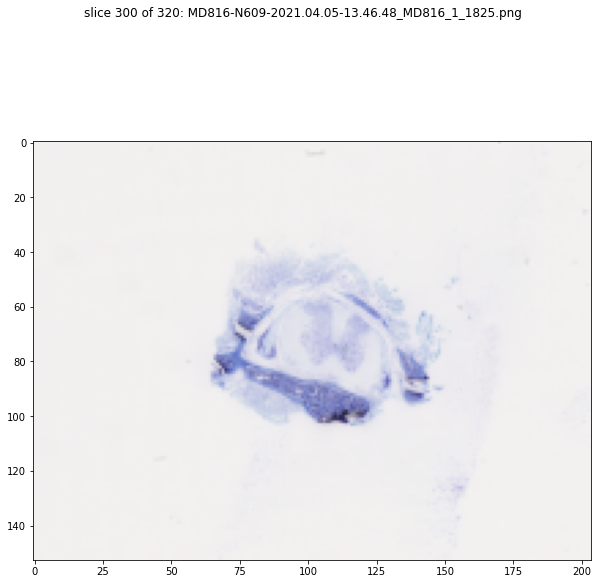

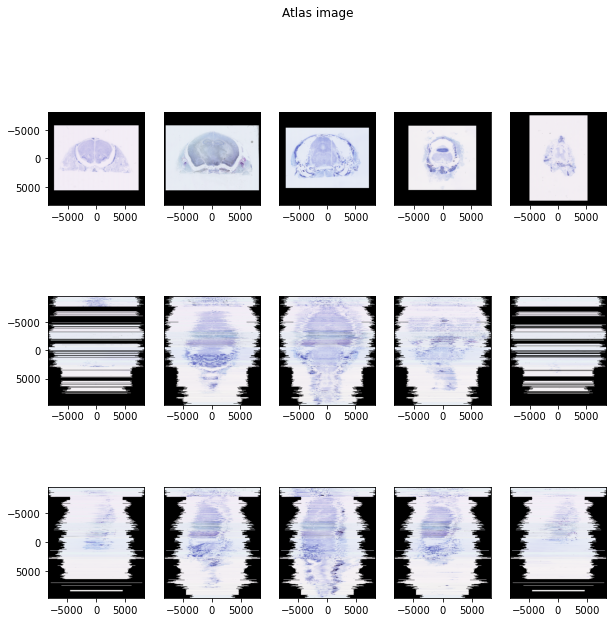

In [51]:
plt.rcParams["figure.figsize"] = (10,10)
# atlas
imp.reload(emlddmm)
xI,I,title,names = emlddmm.read_data(atlas_name)
I = I.astype(float)
# normalize
I /= np.mean(np.abs(I))
dI = np.array([x[1]-x[0] for x in xI])
print(dI)
fig = emlddmm.draw(I,xI)
fig[0].suptitle('Atlas image')

In [52]:
print(names)

['red', 'green', 'blue', 'mask']


In [44]:
I.dtype
print(np.max(I))
print(I.shape)
I_slice = np.transpose(I,(1,2,3,0))[18,:,:,:3]
# plt.imshow(I_slice)
print(I_slice.shape)
print(np.max(I_slice))

1.0
(4, 1950, 212, 262)
(212, 262, 3)
0.9647058844566345


In [13]:
# initial downsampling so there isn't so much on the gpu
mindownI = np.min(np.array(downIs),0)
xI,I = emlddmm.downsample_image_domain(xI,I,mindownI)
downIs = [ list((np.array(d)/mindownI).astype(int)) for d in downIs]
dI = [x[1]-x[0] for x in xI]
print(dI)
nI = np.array(I.shape,dtype=int)
# update our config variable
config['downI'] = downIs

[50.0, 50.0, 50.0]


Found extension .vtk
[64. 64. 64.]


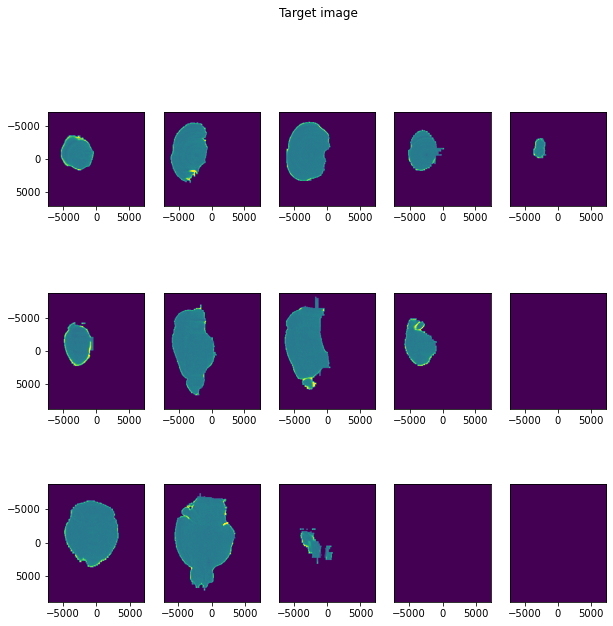

In [14]:
# target
imp.reload(emlddmm)
xJ,J,title,names = emlddmm.read_data(target_name)
J = J.astype(float)
J /= np.mean(np.abs(J))
dJ = np.array([x[1]-x[0] for x in xJ])
print(dJ)
J = J.astype(float)#**0.25
fig = emlddmm.draw(J,xJ)
fig[0].suptitle('Target image')
W0 = np.ones_like(J[0])

In [15]:
# initial downsampling so there isn't so much on the gpu
mindownJ = np.min(np.array(downJs),0)
xJ,J = emlddmm.downsample_image_domain(xJ,J,mindownJ)
W0 = emlddmm.downsample(W0,mindownJ)
downJs = [ list((np.array(d)/mindownJ).astype(int)) for d in downJs]
dJ = [x[1]-x[0] for x in xJ]
nJ = np.array(J.shape,dtype=int)
# update our config variable
config['downJ'] = downJs

Text(0.5, 0.98, 'Initial transformed atlas')

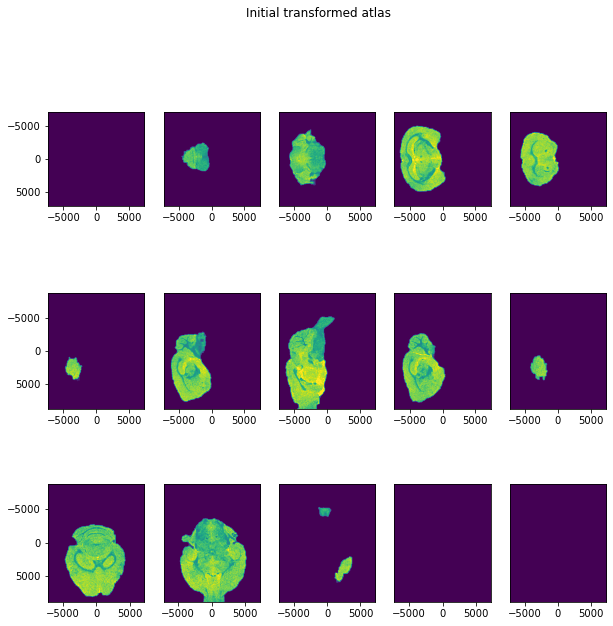

In [16]:
imp.reload(emlddmm)
# visualize initial affine
if 'A' in config:
    A = np.array(config['A']).astype(float)
else:
    A = np.eye(4)
# this affine matrix should be 4x4, but it may be 1x4x4
if A.ndim > 2:
    A = A[0]
Ai = np.linalg.inv(A)
XJ = np.stack(np.meshgrid(*xJ,indexing='ij'),-1)
Xs = (Ai[:3,:3]@XJ[...,None])[...,0] + Ai[:3,-1]
out = emlddmm.interp(xI,I,Xs.transpose((3,0,1,2)))
fig = emlddmm.draw(out,xJ)
fig[0].suptitle('Initial transformed atlas')

In [17]:
print('shape I: ',I.shape)
print('shape J: ', J.shape)

shape I:  (1, 264, 228, 160)
shape J:  (1, 512, 300, 300)


Found 3 scales
dv tensor([150., 150., 150.], device='cuda:0')
a scale is 200.0


/home/brysongray/anaconda3/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180487213/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
[W Copy.cpp:244] Warning: Casting complex values to real discards the imaginary part (function operator())
/home/brysongray/emlddmm/emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 0
Finished iteration 10
Finished iteration 20
Finished iteration 30
Finished iteration 40


/home/brysongray/emlddmm/emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 50
Finished iteration 60
Finished iteration 70
Finished iteration 80
Finished iteration 90


/home/brysongray/emlddmm/emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 100
Finished iteration 110
Finished iteration 120
Finished iteration 130
Finished iteration 140
Iteration 150, linear oscilating, reducing eA to 900000.0


/home/brysongray/emlddmm/emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 150
Finished iteration 160
Finished iteration 170
Finished iteration 180
Finished iteration 190


/home/brysongray/emlddmm/emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 200
Finished iteration 210
Finished iteration 220
Finished iteration 230
Finished iteration 240


/home/brysongray/emlddmm/emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 250
Finished iteration 260
Finished iteration 270
Iteration 280, linear oscilating, reducing eA to 810000.0
Finished iteration 280
Finished iteration 290


/home/brysongray/emlddmm/emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 300
Iteration 310, linear oscilating, reducing eA to 729000.0
Finished iteration 310
Finished iteration 320
Finished iteration 330
Finished iteration 340


/home/brysongray/emlddmm/emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 350
Finished iteration 360
Finished iteration 370
Finished iteration 380
Iteration 390, linear oscilating, reducing eA to 656100.0
Finished iteration 390
Iteration 400, linear oscilating, reducing eA to 590490.0


/home/brysongray/emlddmm/emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 400
Finished iteration 410
Iteration 420, translation oscilating, reducing eA to 531441.0
Finished iteration 420
Iteration 430, linear oscilating, reducing eA to 478296.9
Finished iteration 430
Iteration 440, linear oscilating, reducing eA to 430467.21
Finished iteration 440


/home/brysongray/emlddmm/emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 450
Finished iteration 460
Finished iteration 470
Finished iteration 480
Finished iteration 490


/home/brysongray/emlddmm/emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


dv tensor([150., 150., 150.], device='cuda:0')
a scale is 200.0


/home/brysongray/emlddmm/emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 0
Finished iteration 10
Iteration 20, linear oscilating, reducing eA to 900000.0
Finished iteration 20
Iteration 30, translation oscilating, reducing eA to 810000.0
Finished iteration 30
Iteration 40 reducing ev to 0.9
Iteration 40, translation oscilating, reducing eA to 729000.0
Finished iteration 40
Iteration 50 reducing ev to 0.81
Iteration 50, translation oscilating, reducing eA to 656100.0
Finished iteration 50
Iteration 60, translation oscilating, reducing eA to 590490.0
Finished iteration 60
Iteration 70 reducing ev to 0.7290000000000001
Iteration 70, linear oscilating, reducing eA to 531441.0
Finished iteration 70
Iteration 80, translation oscilating, reducing eA to 478296.9
Finished iteration 80
Iteration 90, linear oscilating, reducing eA to 430467.21
Finished iteration 90
Iteration 100, translation oscilating, reducing eA to 387420.489
Finished iteration 100
Iteration 110, translation oscilating, reducing eA to 348678.4401
Finished iteration 110
Iteration 

/home/brysongray/emlddmm/emlddmm.py:876: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figErr = plt.figure()


Finished iteration 0
Finished iteration 10
Iteration 20, translation oscilating, reducing eA to 900000.0
Finished iteration 20
Iteration 30, translation oscilating, reducing eA to 810000.0
Finished iteration 30
Iteration 40, translation oscilating, reducing eA to 729000.0
Finished iteration 40
Iteration 50, translation oscilating, reducing eA to 656100.0
Finished iteration 50
Iteration 60 reducing ev to 0.9
Iteration 60, translation oscilating, reducing eA to 590490.0
Finished iteration 60
Iteration 70, translation oscilating, reducing eA to 531441.0
Finished iteration 70
Iteration 80, translation oscilating, reducing eA to 478296.9
Finished iteration 80
Iteration 90, translation oscilating, reducing eA to 430467.21
Finished iteration 90


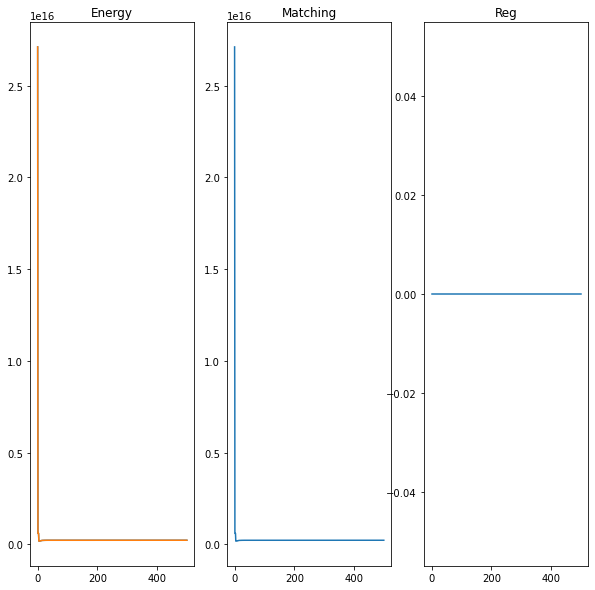

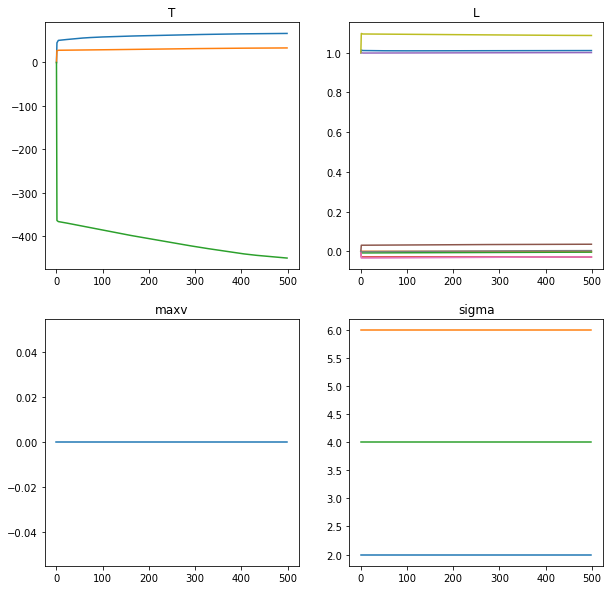

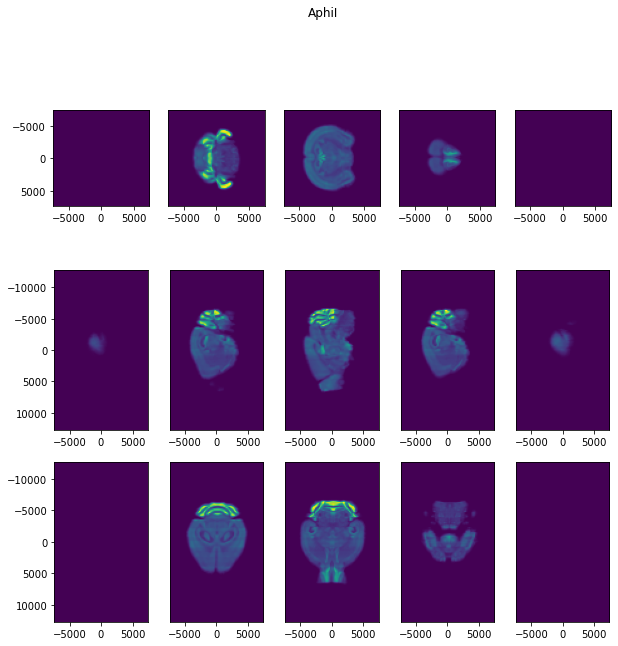

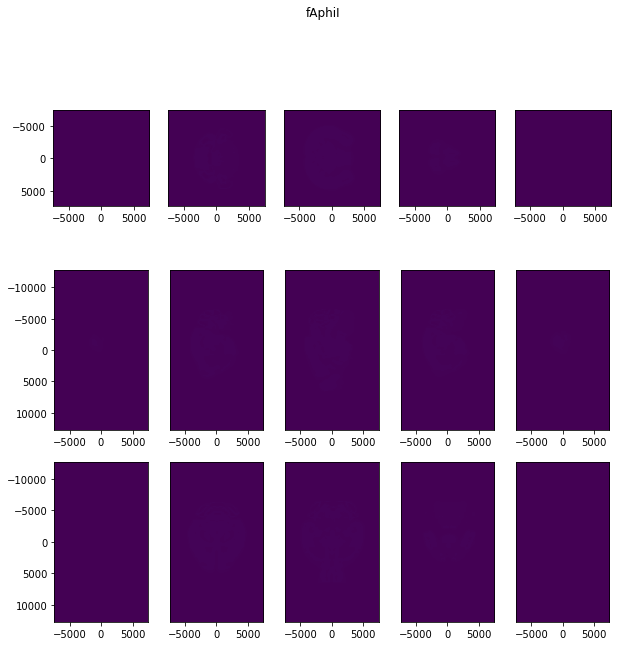

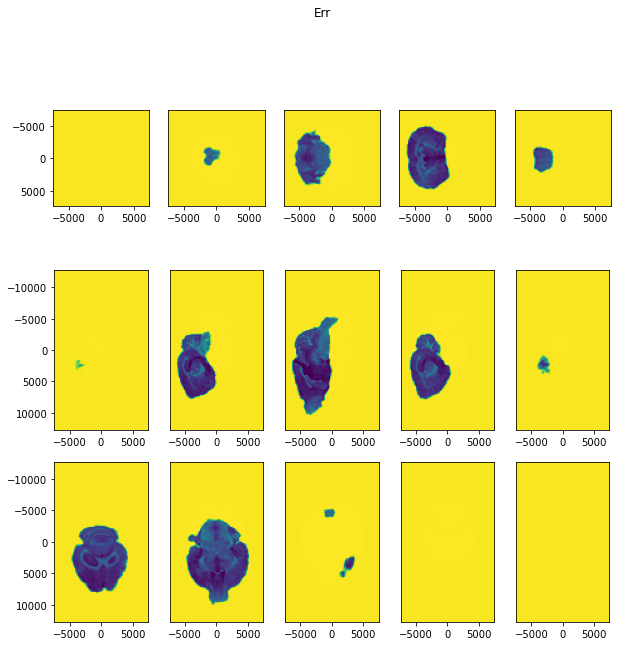

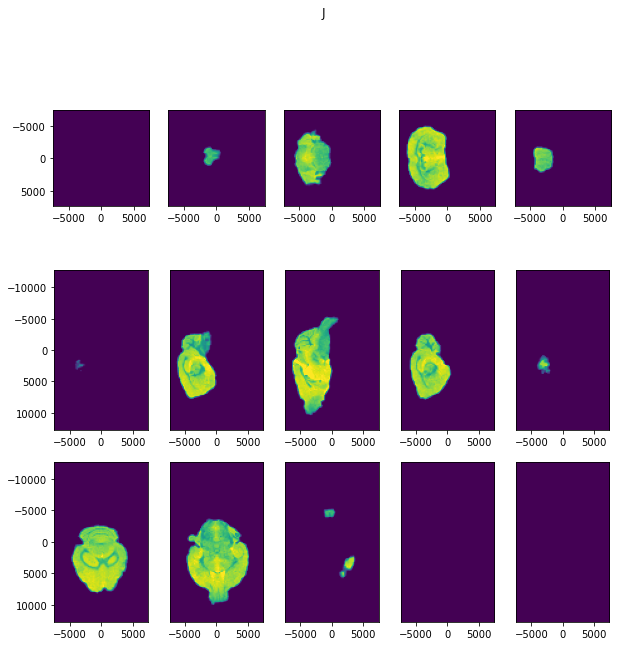

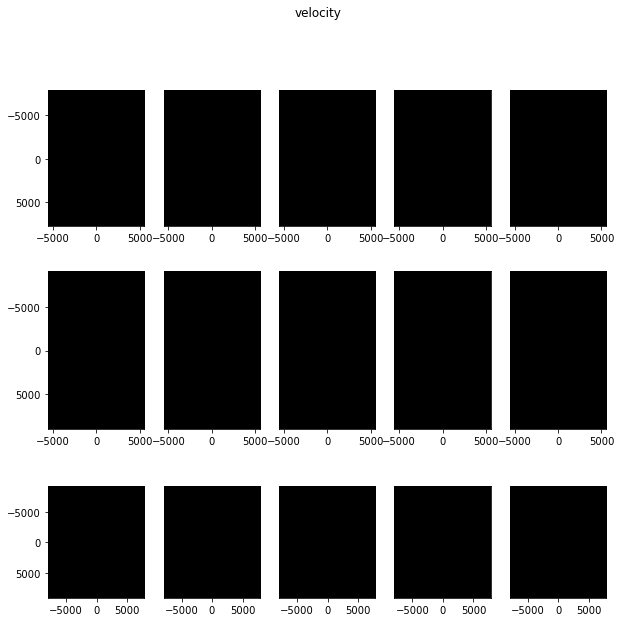

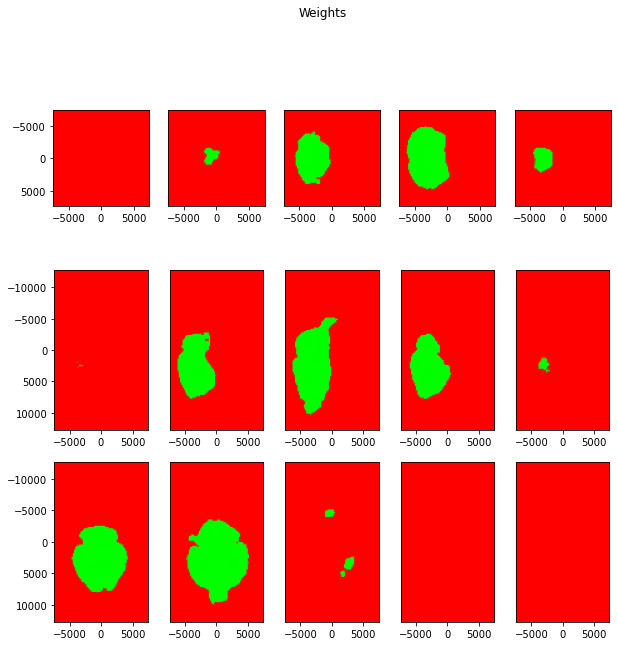

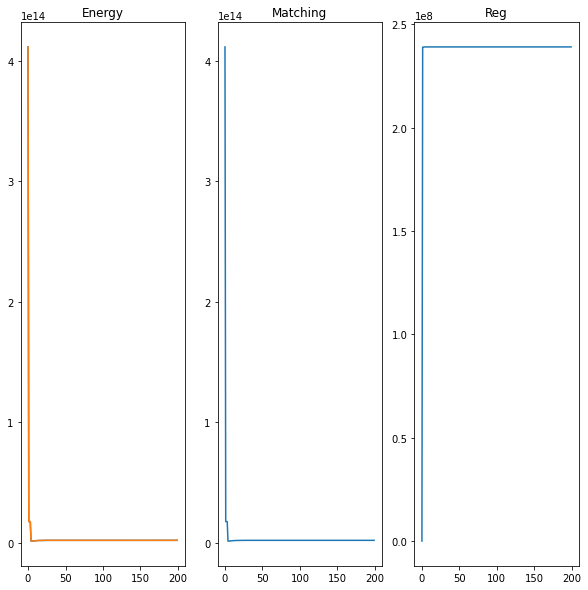

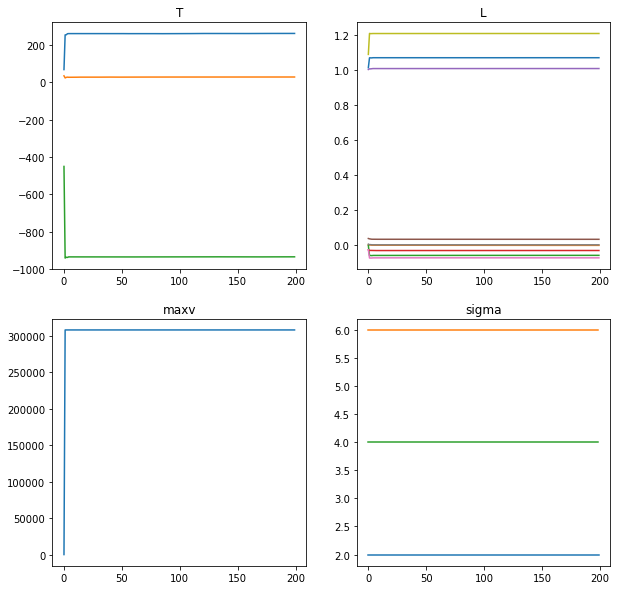

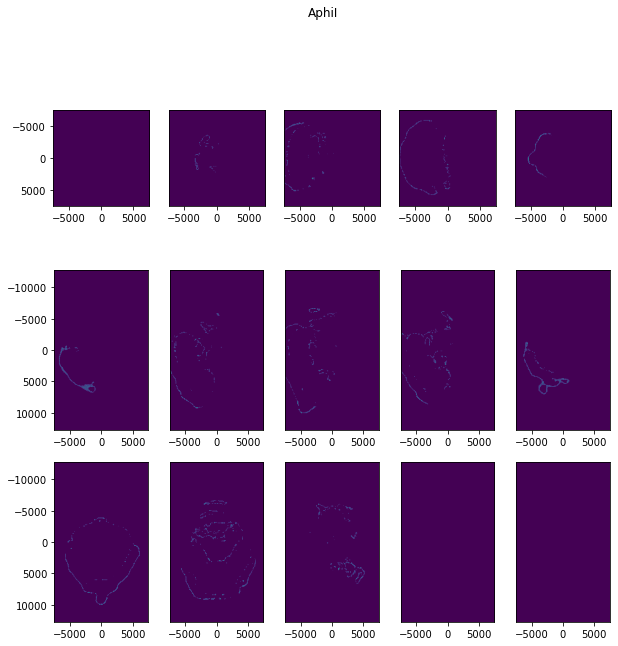

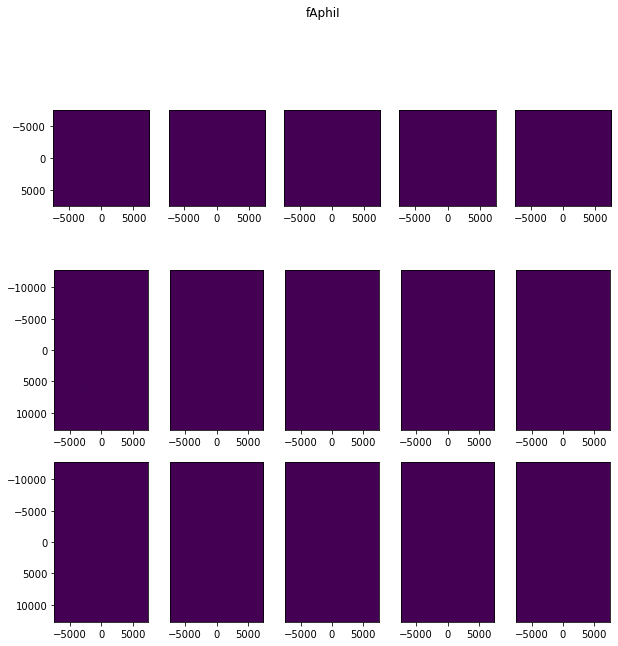

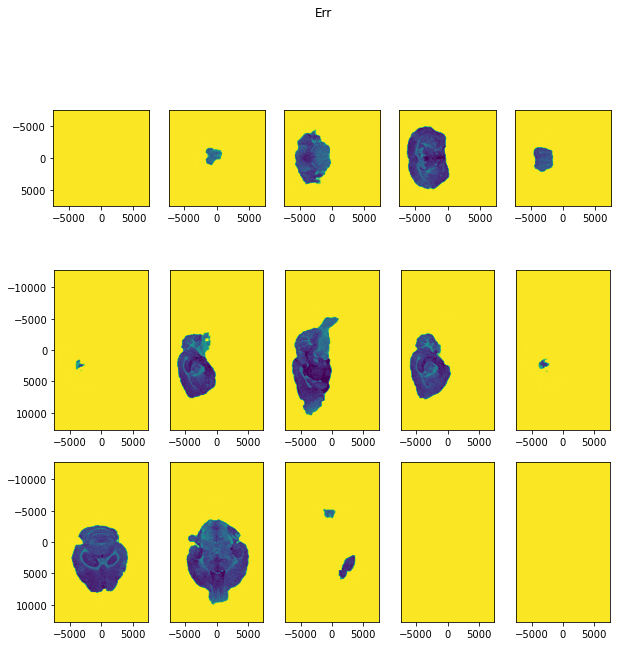

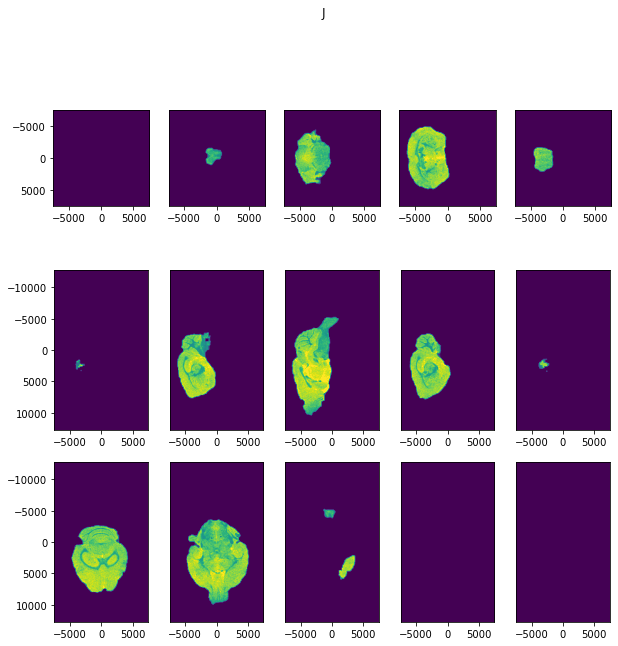

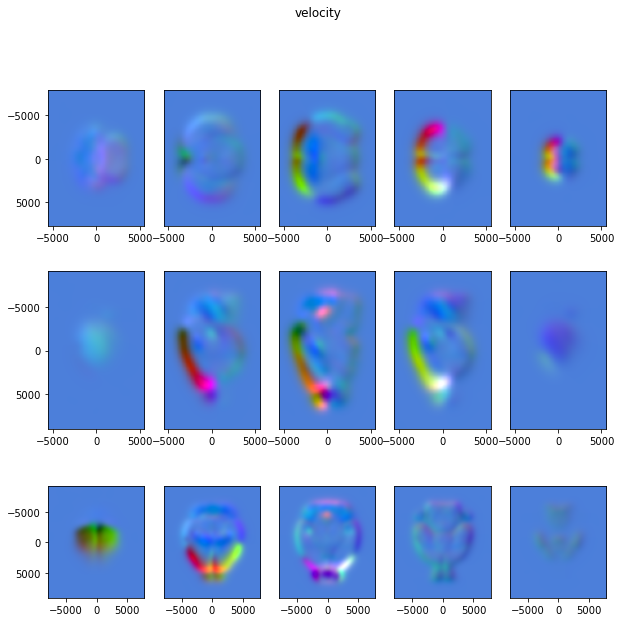

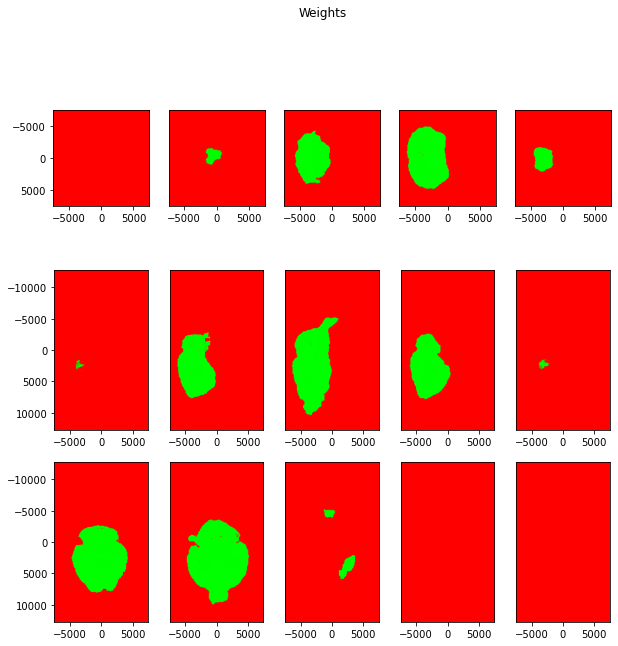

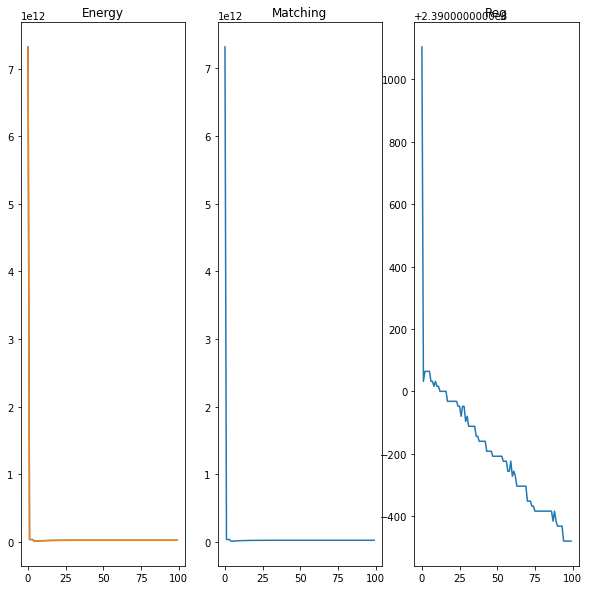

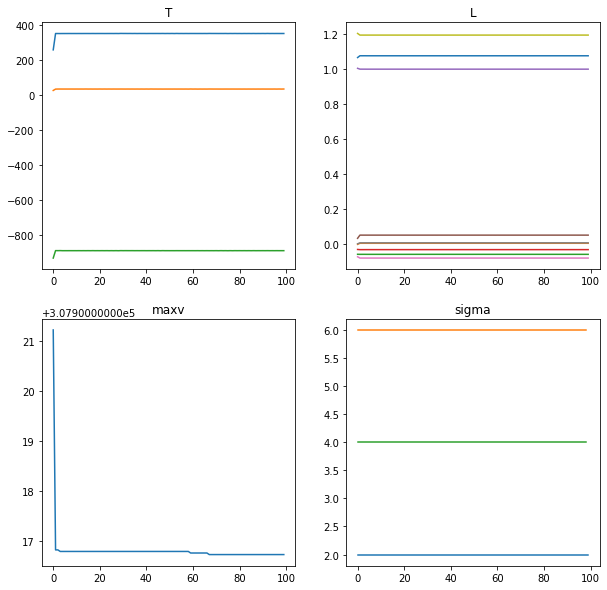

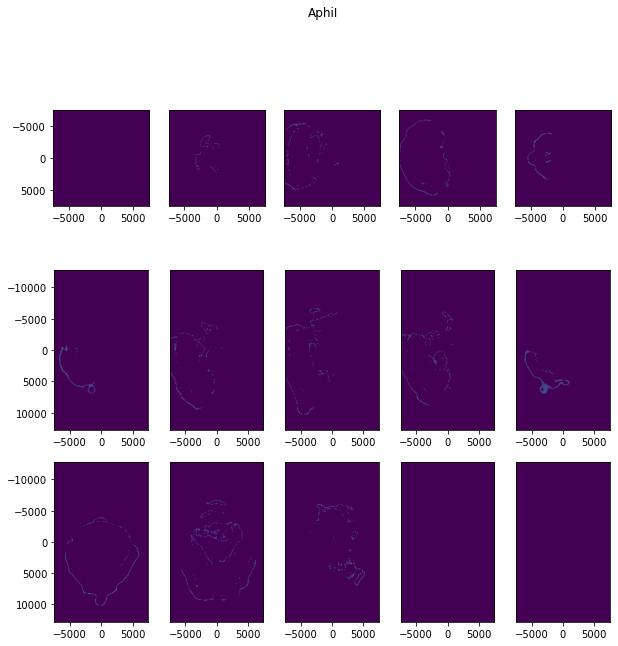

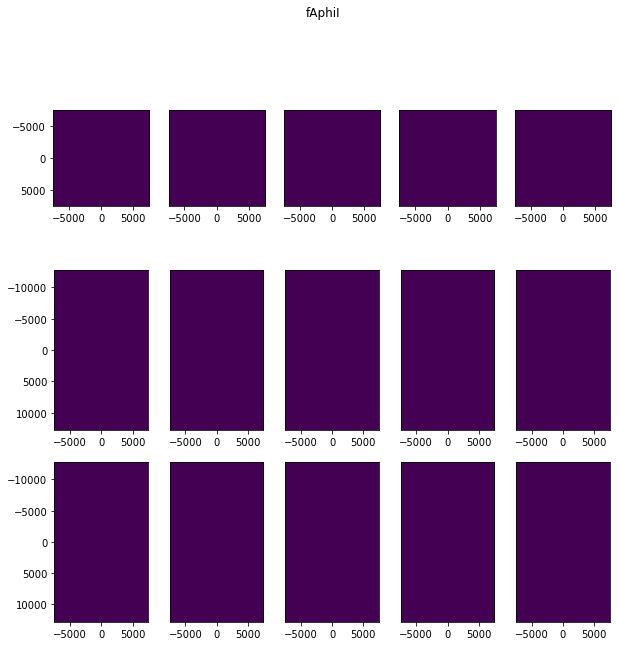

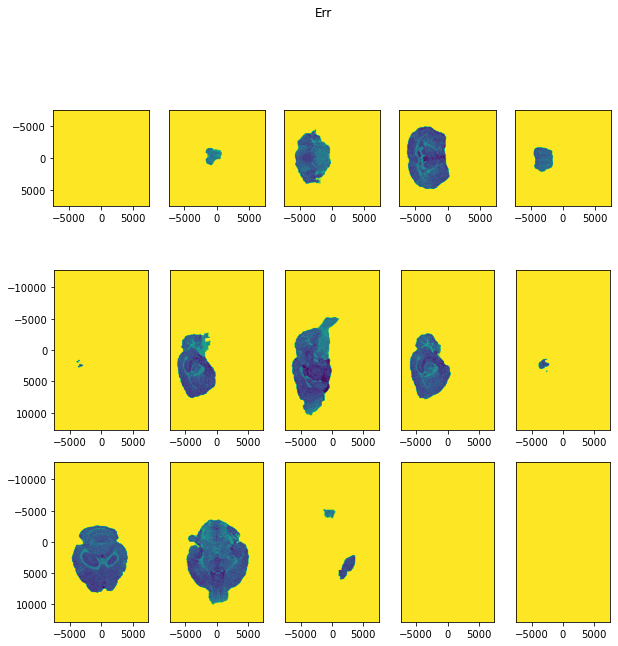

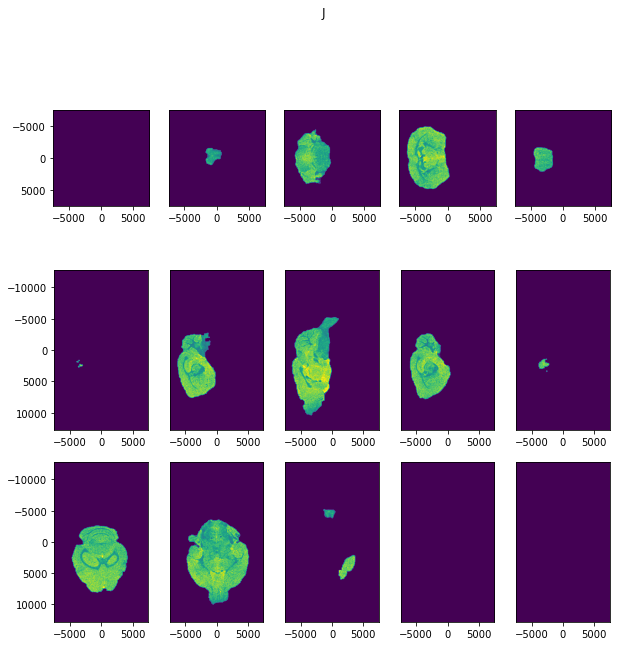

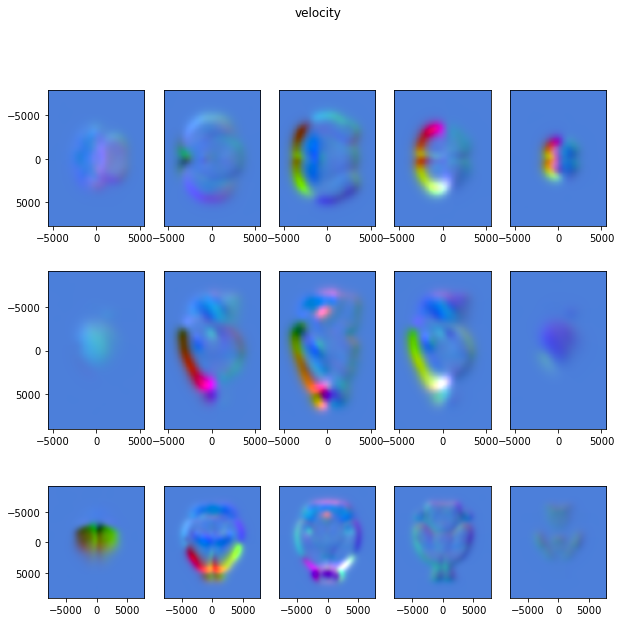

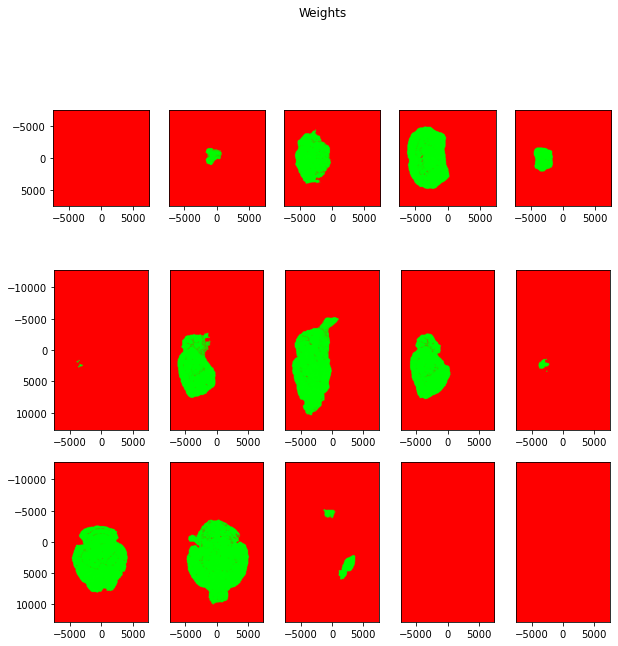

In [18]:
imp.reload(emlddmm)
device = 'cuda:0'
#device = 'cpu'
output = emlddmm.emlddmm_multiscale(I=I,xI=[xI],J=J,xJ=[xJ],W0=W0,device=device,**config)

In [19]:
imp.reload(emlddmm)
emlddmm.write_transform_outputs(output_dir,output[-1])

In [ ]:
# get labels
xS,S,title,names = emlddmm.read_data(label_name)

In [1]:
imp.reload(emlddmm)
emlddmm.write_qc_outputs(output_dir,output[-1],xI,I,xJ,J)#,xS=xS,S=S.astype(float))

NameError: name 'imp' is not defined

In [ ]:
# test it, forward transform is used for computing a transformed target
# that is, visualize the target deformed to match the atlas
imp.reload(emlddmm)
Xin = torch.stack(torch.meshgrid([torch.as_tensor(x) for x in xI]))
Xout = emlddmm.compose_sequence(output_dir,Xin)
Jt = emlddmm.apply_transform_float(xJ,J,Xout)

In [ ]:
import matplotlib.pyplot as plt
emlddmm.draw(Jt,xI)
plt.gcf().suptitle('Transformed target')

In [ ]:
# test it, backward transform is used for computing a transformed atlas
# that is, visualize the atlas deformed to match the target
Xin = torch.stack(torch.meshgrid([torch.as_tensor(x) for x in xJ]))
Xout = emlddmm.compose_sequence(output_dir,Xin,direction='b')
It = emlddmm.apply_transform_float(xI,I,Xout)
St = emlddmm.apply_transform_int(xS,S,Xout)

In [ ]:
St_ = St.float()
emlddmm.draw(It,xJ)
emlddmm.draw(torch.cat((St_%7,St_%5,St_%3)),xJ)

In [ ]:
atlas_output_dir = os.path.join(output_dir,'to_atlas')
if not os.path.isdir(atlas_output_dir): os.mkdir(atlas_output_dir)
target_output_dir = os.path.join(output_dir,'to_target')
if not os.path.isdir(target_output_dir): os.mkdir(target_output_dir)

In [ ]:
# write out
imp.reload(emlddmm)
emlddmm.write_data(os.path.join(atlas_output_dir,'target_to_atlas.vtk'),xI,Jt,'target_to_atlas')

emlddmm.write_data(os.path.join(target_output_dir,'atlas_to_target.vtk'),xI,It,'atlas_to_target')
emlddmm.write_data(os.path.join(target_output_dir,'atlas_seg_to_target.vtk'),xI,St,'atlas_seg_to_target')

In [ ]:
# save config used to output
with open(config_file) as f:
    config = json.load(f)
with open(os.path.join(output_dir, 'config.json'), 'w') as f:
    json.dump(config, f)

In [ ]:
# TODO write out data at original resolution

In [ ]:
# with open('test','wt') as f:
#     f.write()